# <center>Applied Data Science Capstone Project:</center>
## <center>Finding an appropriate place to live in London</center>
### <center>Mario Andrés González Pozo</center>

#### Initialize notebook

Start by installing and importing the libraries needed

In [2]:
pip install geocoder

     |████████████████████████████████| 102kB 18.4MB/s ta 0:00:01
     |████████████████████████████████| 829kB 33.7MB/s eta 0:00:01
     |████████████████████████████████| 81kB 17.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sklearn-pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.21.0-py_0 conda-forge


geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 3

In [5]:
import requests
import pandas as pd
from sklearn_pandas import DataFrameMapper
import matplotlib.pyplot as plt
import numpy as np # library to handle data in a vectorized manner
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#### Getting the data

The data which will serve to cluster the boroughs was preprocessed (mostly) manually and uploaded to GitHub as a csv file.

In [104]:
url = "https://raw.githubusercontent.com/Marititi/IBM-Project/master/LondonBP.csv"
lbp = pd.read_csv(url, index_col=0, sep=';', decimal = ",") #Decimals were separated by comma
lbp.head()

,Population density,Average age,Proportion of population of working-age,Percentage of resident population born abroad,Male employment rate,Female employment rate,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area
Area name,,,,,,,,,,,,,
Barking and Dagenham,57.9,32.9,63.1,37.8,75.6,56.5,11.0,27886,0.5,73.0,83.4,243500,33.6
Barnet,44.9,37.3,64.9,35.2,74.5,62.9,8.5,33443,0.7,73.8,62.7,445000,41.3
Bexley,40.3,39.0,62.9,16.1,82.1,68.5,7.6,34350,0.6,73.5,51.8,275000,31.7
Brent,76.8,35.6,67.8,53.9,76.0,62.6,7.5,29812,0.6,74.4,78.8,407250,21.9
Bromley,21.8,40.2,62.6,18.3,80.4,70.4,5.3,37682,0.6,78.6,64.1,374975,57.8


#### Understanding and preparing the data

Data was previously cleaned so we won't look for missing values, but, the employment rate for male and female will be transformed (ergo, replaced) into a new variable named employment inequality which will represent the employment percentage difference between both groups.

In [7]:
lbp["Employment inequality"] = lbp["Male employment rate"].values - lbp["Female employment rate"].values
lbp.drop(["Male employment rate", "Female employment rate"], axis = 1, inplace = True)

Let's take a look at some statistics to see if there are potential outliers or out of range values due to a source typing error

In [8]:
lbp.describe()

,Population density,Average age,Proportion of population of working-age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,3.200000e+01,32.000000,32.000000
mean,75.856250,36.162500,68.103125,36.512500,6.078125,34328.00000,0.915625,74.065625,84.868750,4.550139e+05,32.243750,12.884375
std,39.201596,2.199963,3.874856,10.495614,1.883328,3787.85751,0.731375,3.043725,31.129329,1.984585e+05,11.926007,4.773118
min,21.800000,31.400000,62.300000,10.900000,3.800000,27886.00000,0.400000,63.800000,50.400000,2.435000e+05,12.400000,4.900000
25%,45.875000,35.000000,64.800000,32.350000,4.575000,31942.75000,0.600000,73.300000,63.800000,3.437500e+05,23.725000,9.050000
50%,61.250000,36.000000,67.650000,36.900000,5.700000,33442.00000,0.650000,74.400000,77.500000,4.086250e+05,31.850000,12.950000
75%,109.500000,37.400000,71.275000,41.850000,7.625000,36864.50000,1.000000,75.850000,99.675000,4.775000e+05,38.550000,15.750000
max,155.600000,40.300000,75.300000,54.100000,11.000000,42141.00000,4.300000,78.800000,212.400000,1.200000e+06,59.300000,21.500000


Max values for crime rate, median house price and jobs density seems a bit off, but not necessarily wrong. Values are probably just outliers and mean relevant information for clustering, so they will be kept as they are.

Correlation is studied between the variables.

In [9]:
lbp.corr()

,Population density,Average age,Proportion of population of working-age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality
Population density,1.000000,-0.573480,0.910875,0.465235,0.126499,0.219550,0.429884,-0.522354,0.683007,0.551975,-0.854751,-0.157027
Average age,-0.573480,1.000000,-0.601702,-0.444412,-0.468358,0.392557,0.071348,0.477066,-0.221329,0.190674,0.588072,-0.218016
Proportion of population of working-age,0.910875,-0.601702,1.000000,0.431468,0.047617,0.260699,0.427855,-0.536294,0.649724,0.464094,-0.774917,-0.231619
Percentage of resident population born abroad,0.465235,-0.444412,0.431468,1.000000,0.183183,-0.155124,0.305315,-0.254914,0.461281,0.402273,-0.522455,0.301131
Unemployment rate,0.126499,-0.468358,0.047617,0.183183,1.000000,-0.322719,0.094870,-0.454547,0.192221,-0.215972,-0.122536,0.292422
Gross annual pay,0.219550,0.392557,0.260699,-0.155124,-0.322719,1.000000,0.578435,0.112226,0.373527,0.690398,0.025007,-0.421012
Jobs density,0.429884,0.071348,0.427855,0.305315,0.094870,0.578435,1.000000,-0.335213,0.880958,0.664152,-0.127118,-0.292113
Two-year business survival rates,-0.522354,0.477066,-0.536294,-0.254914,-0.454547,0.112226,-0.335213,1.000000,-0.547750,-0.110780,0.480099,0.116599
Crime rate,0.683007,-0.221329,0.649724,0.461281,0.192221,0.373527,0.880958,-0.547750,1.000000,0.685903,-0.395287,-0.315059
Median house price,0.551975,0.190674,0.464094,0.402273,-0.215972,0.690398,0.664152,-0.110780,0.685903,1.000000,-0.360281,-0.306143


There is an important correlation between the population density and the proportion of population of working-age. Let's look at a scatter plot to learn more about it.

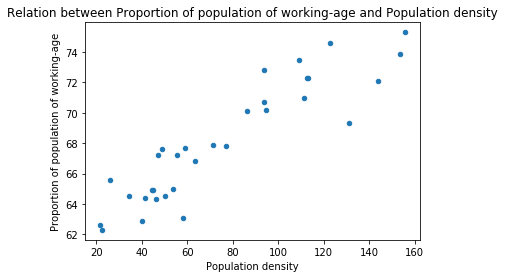

In [10]:
lbp.plot(kind="scatter", x = "Population density", y = "Proportion of population of working-age")
plt.title("Relation between Proportion of population of working-age and Population density")
plt.show()

Looks like the correlation really corresponds to a linear correlation. Also it must be noticed that their correlation with other variables is similar. Considering that, the proportion of population of working-age variable will be removed.

In [11]:
lbp2 = lbp.drop(["Proportion of population of working-age"], axis = 1)
#lbp2.drop(["Kensington and Chelsea"], axis = 0, inplace = True)

To finish the data preparation, every column of the dataframe is normalized via standard score.

In [12]:
mapper = DataFrameMapper([(lbp2.columns, StandardScaler())])
scaled_features = mapper.fit_transform(lbp2.copy())
scaled_lbp = pd.DataFrame(scaled_features, index=lbp2.index, columns=lbp2.columns)
scaled_lbp

,Population density,Average age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality
Area name,,,,,,,,,,,
Barking and Dagenham,-0.465378,-1.506708,0.124633,2.655209,-1.727910,-0.577372,-0.355708,-0.047937,-1.082837,0.115542,1.323052
Barnet,-0.802304,0.525327,-0.127053,1.306531,-0.237380,-0.299539,-0.088666,-0.723545,-0.051266,0.771521,-0.273391
Bexley,-0.921523,1.310432,-1.975980,0.821007,0.005901,-0.438455,-0.188807,-1.079300,-0.921574,-0.046323,0.152327
Brent,0.024459,-0.259777,1.683152,0.767060,-1.211308,-0.438455,0.111615,-0.198072,-0.244525,-0.881205,0.109755
Bromley,-1.400994,1.864624,-1.763014,-0.419776,0.899629,-0.438455,1.513583,-0.677852,-0.409756,2.177189,-0.613965
Camden,0.918608,0.109684,0.473122,-1.121088,1.466659,1.784210,-0.155426,1.260849,1.254197,-0.634148,-1.444115
Croydon,-0.807487,0.386780,-0.688507,-1.067141,-0.437744,-0.438455,0.412037,-0.256821,-0.793588,0.413714,-0.124389
Ealing,-0.325425,0.017318,1.053937,-0.150040,-0.803873,-0.299539,0.578938,-0.305778,-0.128058,-0.114477,0.961191
Enfield,-0.898198,0.063501,-0.146414,-1.228982,-0.730915,-0.438455,0.044855,-0.504870,-0.691199,1.137846,0.322614


Data seems fine to start clustering the boroughs

#### Starting the model: Clustering by borough

The clusters will be decided based on the best cluster given by KMeans function iterating on a variable number of clusters.

In [13]:
LabelDict = {}
CentDict ={}
FreqDict ={}
klist = [4,5,6,7]  #4 to 7 clusters is considered to be a good interval to generate borough clusters
for k in klist:
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, n_init = 500, init = "random").fit(scaled_lbp) #kmeans runs 500 times using "random" seeds

    # save cluster information
    (cluster, counts) = np.unique(kmeans.labels_, return_counts=True)
    labelcount = np.asarray((cluster, counts)).T
    FreqDict["k="+str(k)] = labelcount
    
    LabelDict["k="+str(k)] = kmeans.labels_
    CentDict["k="+str(k)] = kmeans.cluster_centers_
FreqDict

{'k=4': array([[ 0, 16],
        [ 1, 11],
        [ 2,  4],
        [ 3,  1]]), 'k=5': array([[ 0,  4],
        [ 1,  3],
        [ 2,  1],
        [ 3, 13],
        [ 4, 11]]), 'k=6': array([[ 0,  4],
        [ 1,  7],
        [ 2,  3],
        [ 3, 13],
        [ 4,  1],
        [ 5,  4]]), 'k=7': array([[ 0,  3],
        [ 1, 12],
        [ 2,  3],
        [ 3,  4],
        [ 4,  8],
        [ 5,  1],
        [ 6,  1]])}

Every group of clusters is inspected visually to choose the one that makes more sense.

#### k = 4

In [14]:
dfk4 = pd.DataFrame(CentDict["k=4"], columns = lbp2.columns)
dfk4

,Population density,Average age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality
0,-0.776386,0.591715,-0.463442,-0.342227,0.071315,-0.316903,0.618576,-0.643786,-0.359833,0.705497,0.298668
1,0.553409,-0.990303,0.319118,0.703305,-0.699435,-0.299539,-0.671302,0.144627,-0.341298,-0.626404,-0.081818
2,1.344948,0.178958,0.654627,-0.932273,1.114277,0.915981,-0.188807,1.136825,1.782782,-1.226233,-0.619287
3,0.954892,0.710058,1.286262,1.468373,2.095648,4.701458,-1.757675,4.162373,2.380479,0.507425,-1.401543


*Note that the cluster groups (index) may not correspond with the numbers given when the code is ran again. Clusters may don't even be the same, but generally they are the same groups with a different order.*

Cluster 0 (16 boroughs) has a low population density which is relatively older and a few part of them are immigrants. The unemployment is low and could be related to a high business survival rate. Crime rates are low, income is low, and median house prices too but there is a high difference between the employment percentage of males and females (employment is higher for males). This cluster could be described as tranquil boroughs which have a stable but small economy probably having many natural and outdoor areas.

Cluster 1 (11 boroughs) has younger people and a relatively high unemployment rate, low job density along with the lowest mean annual income, but having an according price for the houses. It also has a low business survival rate. Could be boroughs used for residential purposes.

Cluster 2 (4 boroughs) has a high density of people of working age and a considerable percentage of immigrants. The unemployment is low and there isn't much difference between male and female employment rates. The jobs density is high and the income too, having high house prices. The crime rate is considerably higher. This cluster could be seen as an important economic region, probably an industrial or commercial area with many business/workplaces going on and large workforce.

Cluster 3 corresponds to only 1 borough which is clearly different from the others, it has a very high job density and gross annual pay, has the highest migrant resident population, extremely high crime rate and highest median house price, with a great percentage of green areas.

#### k = 5

In [15]:
dfk5 = pd.DataFrame(CentDict["k=5"], columns = lbp2.columns) 
dfk5

,Population density,Average age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality
0,1.344948,0.178958,0.654627,-0.932273,1.114277,0.915981,-0.188807,1.136825,1.782782,-1.226233,-0.619287
1,-1.285230,1.664499,-1.827549,-0.689511,0.909464,-0.345844,1.168654,-0.775766,-0.217691,2.021004,-1.011302
2,0.954892,0.710058,1.286262,1.468373,2.095648,4.701458,-1.757675,4.162373,2.380479,0.507425,-1.401543
3,-0.658961,0.344149,-0.148648,-0.262084,-0.122105,-0.310225,0.491635,-0.613329,-0.392635,0.401918,0.600968
4,0.553409,-0.990303,0.319118,0.703305,-0.699435,-0.299539,-0.671302,0.144627,-0.341298,-0.626404,-0.081818


The cluster 0 from *k=4* iteration is divided into two groups which have their differences, these are the clusters 1 and 2. The other clusters are the same.
Cluster 1 is more similar than the cluster 0 defined previously but some features are more pronounced. The average age from these regions is relatively high and have a low population density of which just a few are immigrants. The job density is low, but the unemployment rate is also low, being similar for both genders. Description for the cluster would be tranquil boroughs  which have a stable but small economy, is inhabited by older people, and having many natural and outdoor areas.
Cluster 2 seems to be another small and stable economy with low population density, having a great difference between employment rate between genders. Other features are average.

#### k = 6

In [16]:
dfk6 = pd.DataFrame(CentDict["k=6"], columns = lbp2.columns) 
dfk6

,Population density,Average age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality
0,1.344948,0.178958,0.654627,-0.932273,1.114277,0.915981,-0.188807,1.136825,1.782782,-1.226233,-0.619287
1,0.574648,-0.721604,-0.028868,0.142815,-0.515032,-0.339229,-0.617980,0.164677,-0.207725,-0.565995,-0.753844
2,-1.285230,1.664499,-1.827549,-0.689511,0.909464,-0.345844,1.168654,-0.775766,-0.217691,2.021004,-1.011302
3,-0.658961,0.344149,-0.148648,-0.262084,-0.122105,-0.310225,0.491635,-0.613329,-0.392635,0.401918,0.600968
4,0.954892,0.710058,1.286262,1.468373,2.095648,4.701458,-1.757675,4.162373,2.380479,0.507425,-1.401543
5,0.516241,-1.460526,0.928093,1.684161,-1.022141,-0.230081,-0.764615,0.109542,-0.575051,-0.732119,1.094228


Cluster 1 from *k=4* iteration is divided into 2 new clusters. The other clusters were kept the same. The new clusters have some notorious difference, and seems like a reasonable division.
Cluster 4 is characterized for having relatively young people and a relatively low income along with the lowest job density. This could be residential areas too that have small businesses.
Cluster 5 has many immigrants and young people and very high unemployment. House prices are low, as well as income and job density. Overall, this cluster has boroughs with a relatively bad economy in global terms, i.e., in a sense of inequality where poverty coexist with a minority of people who has a good status. Given there is a low greenspace percentage, the area is probably associated with residential and commercial areas.

#### k = 7

Since there are 2 clusters with a single borough, and 3 with 3-4 boroughs, it will be considered that the model is kind of overfitting the clusters, when a more general view is required. We will stop at this point and consider k=6 as the number of clusters to use onwards.

Next, a dataframe with the labels to be used (k=6) is saved as a csv file, this way the clusters are the same on every run, despite of the ones obtained before. (Alternatively, a constant seed could've been used)

In [17]:
lbp3 = lbp2.copy(deep = True)
lbp3["Label"] = LabelDict.get("k=6").astype(int)
#lbp3.to_csv("Data+Cluster")    #Cluster labels are saved merging it into the dataframe

Now that we have our clusters, the idea is that by using the cluster description which may or not be complemented with the cluster centroids we select a cluster that matches our preferences/requirements. Given a cluster choice, the name of the boroughs within a cluster will be displayed.
Finally, we will be giving additional information about the venues, showing the most common venues around.

#### Foursquare model: Getting the venues

##### Function definition

A function to get the most common venues from a location is defined, taking as a parameter the number of top venues to be obtained.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

This function uses foursquare API to get the nearby venues given a location

In [39]:
LIMIT = 100  #This is the maximum number of venues to get. Can't get past 100.
def getNearbyVenues(names, latitudes, longitudes, radius=7000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Getting the venues

The latitude and longitude of the boroughs will be needed, so we get them through the use of geocode.

In [86]:
lbp4 = pd.read_csv("https://raw.githubusercontent.com/Marititi/IBM-Project/master/Data%2BCluster")
lbp4.set_index('Area name', drop=True, inplace = True)
geolocator = Nominatim(user_agent="explorer")
lbp4["Latitude"] = ""
lbp4["Longitude"] = ""
for i in lbp4.index:  
    location = geolocator.geocode(i+", London")
    longitude = location.longitude
    lbp4["Latitude"][i] = location.latitude
    lbp4["Longitude"][i] = location.longitude
lbp4.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Population density,Average age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality,Label,Latitude,Longitude
Area name,,,,,,,,,,,,,,
Barking and Dagenham,57.9,32.9,37.8,11.0,27886,0.5,73.0,83.4,243500,33.6,19.1,5,51.5541,0.150504
Barnet,44.9,37.3,35.2,8.5,33443,0.7,73.8,62.7,445000,41.3,11.6,2,51.6488,-0.172913
Bexley,40.3,39.0,16.1,7.6,34350,0.6,73.5,51.8,275000,31.7,13.6,2,51.4417,0.150488
Brent,76.8,35.6,53.9,7.5,29812,0.6,74.4,78.8,407250,21.9,13.4,4,51.5638,-0.27576
Bromley,21.8,40.2,18.3,5.3,37682,0.6,78.6,64.1,374975,57.8,10.0,1,51.4028,0.0148142


Identify Foursquare credential

In [21]:
CLIENT_ID = 'LRVBFQOYZSMKZFV1NYIREL3BWHUE35BDNI5FNFF1S3I0P1ZK' # your Foursquare ID
CLIENT_SECRET = '4HOJSATKGIYBKZJ4UZSWC14FLO5DSYBKX5AOTWIWHJRQLKPM' # your Foursquare Secret
VERSION = '20200216'

Create a dataframe with the top 10 venues

In [40]:
venues = getNearbyVenues(names=lbp3.index, latitudes=lbp3['Latitude'], longitudes=lbp3['Longitude'])

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


We use dummy variables to get a new dataframe of each borough and its venues

In [23]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot.index = venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

A dataframe with the most common venues per borough is created

In [103]:
Bgroup = onehot.groupby('Borough').mean().reset_index()

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Borough'] = Bgroup['Borough']


for ind in np.arange(Bgroup.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(Bgroup.iloc[ind, :], num_top_venues)

venues_sorted.head(5)

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Park,Coffee Shop,Pub,Café,Supermarket,Clothing Store,Portuguese Restaurant,Grocery Store,Gym,Gym / Fitness Center
1,Barnet,Café,Coffee Shop,Pub,Park,Supermarket,Turkish Restaurant,Bakery,Golf Course,Pizza Place,Bar
2,Bexley,Pub,Park,Grocery Store,Coffee Shop,Gym / Fitness Center,Café,Furniture / Home Store,Supermarket,Italian Restaurant,Golf Course
3,Brent,Park,Pub,Pizza Place,Café,Coffee Shop,Middle Eastern Restaurant,Bakery,Gym / Fitness Center,Portuguese Restaurant,Indian Restaurant
4,Bromley,Pub,Park,Pizza Place,Gym / Fitness Center,Coffee Shop,Indian Restaurant,Italian Restaurant,Gastropub,Café,Bar


#### Making the model work

We have everything we need to display the information needed, let's give it a try by using an example.

##### Example
Let's say we would like to move to London and have no idea where. We'll look through the clusters to get an idea of the types of boroughs inside London, and match what we want.

We'll make use of our cluster characterization from before, which is the following:

- Cluster 0 corresponds to only 1 borough which is clearly different from the others, it has a very high job density and gross annual pay, has the highest migrant resident population, extremely high crime rate and highest median house price, with a great percentage of green areas.

- Cluster 1 has a relatively high average age and a low population density of which just a few are immigrants. The job density is low, but the unemployment rate is also low, being similar for both genders. Description for the cluster would be tranquil boroughs  which have a stable but small economy, is inhabited by older people, and having many natural and outdoor areas.

- Cluster 2 seems to be another small and stable economy with low population density, having a great difference between employment rate between genders. Other features are average.

- Cluster 3 has a high density of people of working age and a considerable percentage of immigrants. The unemployment is low and there isn't much difference between male and female employment rates. The jobs density is high and the income too, having high house prices. The crime rate is considerably higher. This cluster could be seen as an important economic region, probably an industrial or commercial area with many business/workplaces going on and large workforce.

- Cluster 4 is characterized for having relatively young people and a relatively low income along with the lowest job density. This could be residential areas too that have small businesses. It's similar to cluster 5, being the most notorious difference, the different employment rates between genders.

- Cluster 5 has many immigrants and young people and very high unemployment. House prices are low, as well as income and job density. Overall, this cluster has boroughs with a relatively bad economy in global terms, i.e., in a sense of inequality where poverty coexist with a minority of people who has a good status. Given there is a low greenspace percentage, the area is probably associated with residential and commercial areas.

The mean values of clusters data are showed as a complimentary information for the cluster definitions.

In [77]:
lbp4.groupby('Label').mean().round(1).reset_index().set_index('Label', drop=True)

,Population density,Average age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality
Label,,,,,,,,,,,
0,112.7,37.7,49.8,8.8,42141.0,4.3,68.8,212.4,920000.0,38.2,6.3
1,26.3,39.8,17.6,4.8,37718.7,0.7,77.6,61.1,412491.7,56.0,8.1
2,50.4,36.9,35.0,5.6,33872.8,0.7,75.5,66.1,378319.2,37.0,15.7
3,127.8,36.6,43.3,4.4,38482.2,1.6,73.5,119.7,803250.0,17.8,10.0
4,95.4,34.7,38.4,6.5,32083.4,0.7,72.5,88.5,413539.9,25.1,9.8
5,102.1,32.1,43.5,9.8,30752.3,0.8,70.9,91.4,321166.7,24.2,19.6


Let's say we are interested in a tranquil borough with many green areas and kind of peaceful, also we won't be working, so **cluster 1** could be fine, and we choose it in the following step.
Now we're interested in knowing what kind of venues are common between the places that match the description given, and we'll choose according to that.

In [90]:
cluster_number = input("Enter a cluster number (0 to 5 admitted):")
cluster_borough = list(lbp4[lbp4["Label"] == int(cluster_number)].index)
cluster_venues = venues_sorted[venues_sorted["Borough"].isin(cluster_borough)]
cluster_venues

Enter a cluster number (0 to 5 admitted): 1


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bromley,Pub,Park,Pizza Place,Gym / Fitness Center,Coffee Shop,Indian Restaurant,Italian Restaurant,Gastropub,Café,Bar
14,Havering,Hotel,Park,Cocktail Bar,Coffee Shop,Pizza Place,Bookstore,Ice Cream Shop,Clothing Store,Gym / Fitness Center,Movie Theater
25,Richmond upon Thames,Pub,Garden,Park,Café,Coffee Shop,Botanical Garden,Gastropub,Italian Restaurant,Rugby Stadium,Hotel


We seem to have 3 options which match our preferences. We're not interested in hotels, but we would like to have some restaurants or food related venues nearby. In this case, **Bromley** seems like a good candidate. 
This is as far as the model goes. A user would like to investigate further about Bromley to verify other matching criterias which aren't considered here.

We can try to verify the cluster information to see if each borough actually matches the cluster description:

In [100]:
lbp4[lbp4.index.isin(cluster_borough)]

,Population density,Average age,Percentage of resident population born abroad,Unemployment rate,Gross annual pay,Jobs density,Two-year business survival rates,Crime rate,Median house price,Percentage of Greenspace area,Employment inequality,Label,Latitude,Longitude
Area name,,,,,,,,,,,,,,
Bromley,21.8,40.2,18.3,5.3,37682,0.6,78.6,64.1,374975,57.8,10.0,1,51.4028,0.0148142
Havering,22.6,40.3,10.9,5.3,33398,0.6,75.3,62.9,287500,59.3,9.5,1,51.5444,-0.144303
Richmond upon Thames,34.4,38.8,23.7,3.8,42076,0.8,78.8,56.3,575000,50.8,4.9,1,51.4404,-0.308151


Boroughs seems pretty alike, with some exception like median house price (we can't expect them to be identical). Anyway I would say they match the cluster description.